## Курсовой проект для курса "Алгоритмы анализа данных"

**Задание:** предсказать средний балл на экзамене по математике, который получают ученики репетиторов из датасета test.csv. Даны два датасета: train.csv (содержит признаки и целевую переменную) и test.csv (только признаки).

**Целевая переменная:** mean_exam_points - целевое значение, средний балл за экзамен учеников

**Метрика качества:** R2 - коэффициент детерминации

**Описание датасета:**
<ul>
    <li>Id - айди</li>
    <li>age - возраст преподавателя</li>
    <li>years_of_experience - стаж преподавателя</li>
    <li>qualification - квалификация преподавателя</li>
    <li>physics - преподает ли физику</li>
    <li>chemistry - преподает ли химию</li>
    <li>biology - преподает ли биологию</li>
    <li>english - преподает ли английский</li>
    <li>geography - преподает ли географию</li>
    <li>history - преподает ли историю</li>
    <li>mean_exam_points - целевое значение, средний балл за экзамен учеников</li>
    </ul>

## Содержание
* [Подготовка датасет, оптимизация](#prep)
* [1. Распределение целевой переменной](#target)
* [2. Анализ признаков и корректировка данных](#features)
    * [2.1 Количественные признаки](#num_features)
    * [2.2 Категориальные/бинарные признаки](#cat_features)
    * [2.3 Матрица корреляций](#corr)
* [3. Анализ зависимости таргета от фичей](#target_features)
    * [3.1 Количественные признаки](#num_features_target)
    * [3.2 Категориальные / бинарные признаки](#cat_bin_features)
* [4. Моделирование](#model)
    * [4.1 Отбор факторов](#model_factor)
    * [4.2 Стандартизация](#model_standart)    
    * [4.3 Разбиение на train/test](#model_devide)
    * [4.4 Линейная регрессия](#model_lr)
    * [4.5 Дерево решений](#model_tree)
    * [4.6 Градиентный бустинг (XGBoost)](#model_gradbust)
    * [4.7 Выбор лучшей модели](#choose)
* [5. Прогнозирование](#estimate)
    * [5.1 Обработка данных](#est_ev)
    * [5.2 Применение модели и сохранение](#est_save)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Подготовка dataset, оптимизация<a class='anchor' id='prep'>

In [2]:
#Пути к директориям
DATASET_PATH = 'train.csv'
PREPARED_DATASET_PATH = 'train_prepared.csv'

In [3]:
test = pd.read_csv('test.csv')

In [4]:
#Данные
data_row = pd.read_csv(DATASET_PATH, sep=',')
data_row.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,61
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,76
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57


In [5]:
#оптимизация памяти
def reduce_mem_usage(data_row):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = data_row.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is: {:.2f} MB'.format(start_mem))
    
    for col in data_row.columns:
        col_type = data_row[col].dtype
        
        if col_type != object:
            c_min = data_row[col].min()
            c_max = data_row[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data_row[col] = data_row[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data_row[col] = data_row[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data_row[col] = data_row[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data_row[col] = data_row[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data_row[col] = data_row[col].astype(np.float32)
                else:
                    data_row[col] = data_row[col].astype(np.float64)
        else:
            data_row[col] = data_row[col].astype('category')

    end_mem = data_row.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data_row

In [6]:
data_row.dtypes

Id                       int64
age                    float64
years_of_experience    float64
lesson_price           float64
qualification          float64
physics                float64
chemistry              float64
biology                float64
english                float64
geography              float64
history                float64
mean_exam_points         int64
dtype: object

In [7]:
data_row = reduce_mem_usage(data_row)

Memory usage of dataframe is: 0.92 MB
Memory usage after optimization is: 0.41 MB
Decreased by 55.2%


In [8]:
#функция стандартизации
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [9]:
#запись результатов моделей
results_all = {}

# 1. Распределение целевой переменной<a class='anchor' id='target'>

In [10]:
#данные медианы, моды, среднего по среднему баллу учеников
data_median = data_row['mean_exam_points'].median()
data_mode = data_row['mean_exam_points'].mode()[0]
data_mean = round(data_row['mean_exam_points'].mean(), 2)
data_row['mean_exam_points'].isnull().astype(np.int).sum()
print('МИН', data_row['mean_exam_points'].min())
print('МАКС', data_row['mean_exam_points'].max())
print('МЕДИАНА', data_row['mean_exam_points'].median())
print('Мода', data_row['mean_exam_points'].mode()[0])
print('Пропуски', data_row['mean_exam_points'].isnull().astype(np.int).sum())

МИН 32
МАКС 100
МЕДИАНА 63.0
Мода 63
Пропуски 0


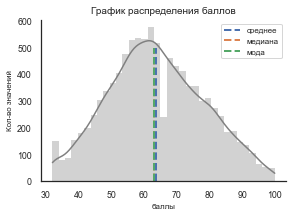

In [11]:
#график распределения баллов
sns.set(font_scale=0.8, style='white')
sns.displot(data_row['mean_exam_points'], kde=True, color='grey', alpha = 0.35, lw=0, height=3, aspect=1.4)
y = np.linspace(0, 500, 10)
plt.plot([data_mean] * 10, y, label='среднее',  linewidth=2, linestyle='--')
plt.plot([data_median] * 10, y, label='медиана',  linewidth=2, linestyle='--')
plt.plot([data_mode] * 10, y, label='мода',  linewidth=2, linestyle='--')
plt.title('График распределения баллов', fontsize=10)
plt.xlabel('баллы', fontsize=8)
plt.ylabel('Кол-во значений', fontsize=8)
plt.legend(fontsize=8)
plt.show()

В целом распределение баллов близко к логнормальному, заметный выброс есть в левом хвосте, в центре заметный провал и выброс. Медиана, мода, среднее - близки. Пропусков в значениях баллов нет.

# 2. Анализ признаков и корректировка данных<a class='anchor' id='features'>

### 2.1 Количественные признаки<a class='anchor' id='num_features'>

In [12]:
data_num_features = data_row[['age', 'years_of_experience', 'lesson_price', 'qualification']]
data_num_features

,age,years_of_experience,lesson_price,qualification
0,40.0,0.0,1400.0,1.0
1,48.0,4.0,2850.0,3.0
2,39.0,0.0,1200.0,1.0
3,46.0,5.0,1400.0,1.0
4,43.0,1.0,1500.0,1.0
...,...,...,...,...
9995,44.0,0.0,1700.0,2.0
9996,51.0,0.0,1700.0,2.0
9997,34.0,1.0,1250.0,1.0
9998,33.0,3.0,1100.0,1.0


In [13]:
mean_data_f = np.mean(data_num_features).round(1)
min_data_f = np.min(data_num_features, axis = 0).round(1)
max_data_f = np.max(data_num_features, axis = 0).round(1)
null_data_f = data_num_features.isnull().astype(np.int).sum()

In [14]:
keys_data_f = mean_data_f.keys()
np.column_stack([keys_data_f, mean_data_f, min_data_f, max_data_f, null_data_f])

array([['age', 45.900001525878906, 23.0, 68.0, 0],
       ['years_of_experience', 2.0, 0.0, 10.0, 0],
       ['lesson_price', 1699.0999755859375, 200.0, 3950.0, 0],
       ['qualification', 1.7000000476837158, 1.0, 4.0, 0]], dtype=object)

(array([4884.,    0.,    0., 3087.,    0.,    0., 1979.,    0.,    0.,
          50.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

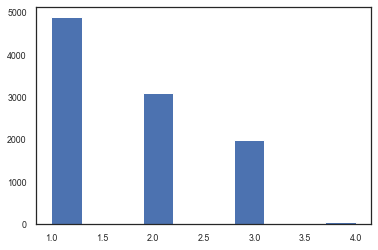

In [15]:
plt.hist(data_row['qualification'])

(array([  19.,  154., 2433., 3323., 1338., 1738.,  639.,  269.,   74.,
          13.]),
 array([ 200.,  575.,  950., 1325., 1700., 2075., 2450., 2825., 3200.,
        3575., 3950.], dtype=float32),
 <BarContainer object of 10 artists>)

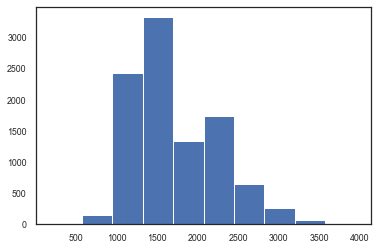

In [16]:
plt.hist(data_row['lesson_price'])

(array([2785., 1757., 1804., 1572., 1122.,  584.,  282.,   70.,   20.,
           4.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       dtype=float32),
 <BarContainer object of 10 artists>)

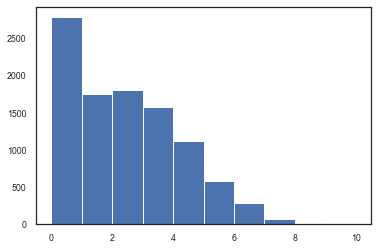

In [17]:
plt.hist(data_row['years_of_experience'])

(array([ 125.,  246.,  868., 1273., 2295., 1901., 1884.,  824.,  445.,
         139.]),
 array([23. , 27.5, 32. , 36.5, 41. , 45.5, 50. , 54.5, 59. , 63.5, 68. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

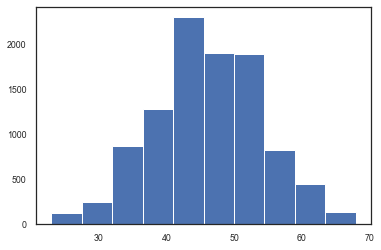

In [18]:
plt.hist(data_row['age'])

Пропущенных значений нет, выбросов для корректировок - тоже.

По квалификации количество преподавателей уровня 4 - минимальное (40 из 10 000)

### 2.2 Категориальные / бинарные признаки<a class='anchor' id='cat_features'>

In [19]:
data_categ_features = data_row[['physics', 'chemistry', 'biology', 'english', 'geography', 'history']]
data_categ_features

,physics,chemistry,biology,english,geography,history
0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
9995,1.0,1.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0
9997,1.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
mean_data_c = np.mean(data_categ_features).round(1)
min_data_c = np.min(data_categ_features, axis = 0).round(1)
max_data_c = np.max(data_categ_features, axis = 0).round(1)
null_data_c = data_categ_features.isnull().astype(np.int).sum()

In [21]:
keys_data_c = mean_data_c.keys()
np.column_stack([keys_data_c, mean_data_c, min_data_c, max_data_c, null_data_c])

array([['physics', 0.4000000059604645, 0.0, 1.0, 0],
       ['chemistry', 0.10000000149011612, 0.0, 1.0, 0],
       ['biology', 0.10000000149011612, 0.0, 1.0, 0],
       ['english', 0.10000000149011612, 0.0, 1.0, 0],
       ['geography', 0.0, 0.0, 1.0, 0],
       ['history', 0.0, 0.0, 1.0, 0]], dtype=object)

In [22]:
data_c = {}
data_c_p = [len(data_categ_features[data_categ_features['physics'] == 0]), 
            len(data_categ_features[data_categ_features['physics'] == 1])]
data_c.update({'physics': data_c_p})
data_c_c = [len(data_categ_features[data_categ_features['chemistry'] == 0]), 
            len(data_categ_features[data_categ_features['chemistry'] == 1])]
data_c.update({'chemistry': data_c_c})
data_c_b = [len(data_categ_features[data_categ_features['biology'] == 0]), 
            len(data_categ_features[data_categ_features['biology'] == 1])]
data_c.update({'biology': data_c_b})
data_c_e = [len(data_categ_features[data_categ_features['english'] == 0]), 
            len(data_categ_features[data_categ_features['english'] == 1])]
data_c.update({'english': data_c_e})
data_c_g = [len(data_categ_features[data_categ_features['geography'] == 0]), 
            len(data_categ_features[data_categ_features['geography'] == 1])]
data_c.update({'geography': data_c_g})
data_c_h = [len(data_categ_features[data_categ_features['history'] == 0]), 
            len(data_categ_features[data_categ_features['history'] == 1])]
data_c.update({'history': data_c_h})

data_c

{'physics': [6250, 3750],
 'chemistry': [8671, 1329],
 'biology': [8904, 1096],
 'english': [9463, 537],
 'geography': [9679, 321],
 'history': [9806, 194]}

Видно, что совсем мало учителей истории, географии, английского

### 2.3 Матрица корреляций<a class='anchor' id='corr'>

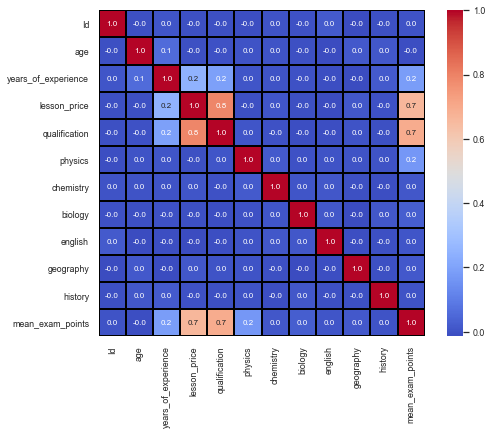

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(data_row.corr(), cmap= 'coolwarm', linewidths=1, fmt='.1f', annot=True, linecolor='black', square=True, annot_kws={'size':8})
plt.show()

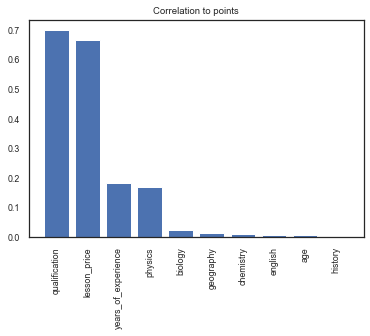

In [24]:
corrmat = data_row.loc[:, data_row.columns != 'Id'].corrwith(
    data_row['mean_exam_points']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to points')
plt.xticks(rotation='vertical')
plt.show()

Ожидаемо, высокая корреляция между баллами и ценой за обучение, а также квалификации и между двумя этими факторами между собой.
Также есть корреляция менее сильная с опытом и обучением физикой.

# 3. Анализ зависимости таргета от признаков<a class='anchor' id='target_features'>

## 3.1 Количественные признаки<a class='anchor' id='num_features_target'>

C:\Users\artemiyb1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


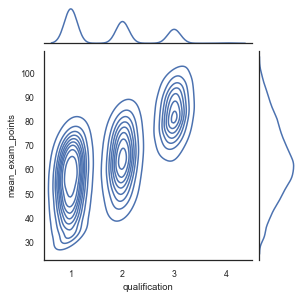

In [25]:
grid = sns.jointplot(data_row['qualification'], data_row['mean_exam_points'], kind='kde')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)

plt.show()

C:\Users\artemiyb1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


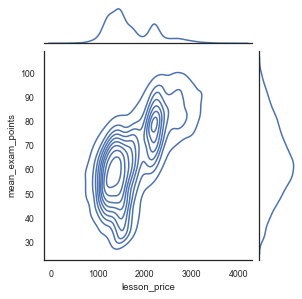

In [26]:
grid = sns.jointplot(data_row['lesson_price'], data_row['mean_exam_points'], kind='kde')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)

plt.show()

В целом на графиках отражена картина, соответствующая корреляцинной матрицы, построенной выше. 

## 3.2 Категориальные / бинарные признаки<a class='anchor' id='cat_bin_features'>

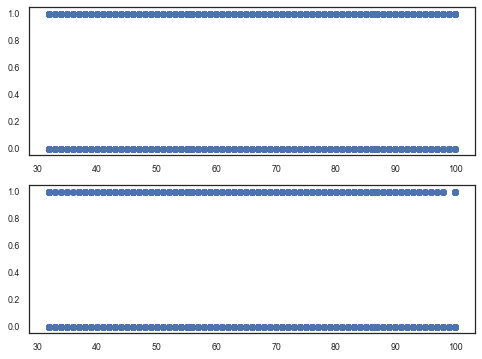

In [27]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.scatter(data_row['mean_exam_points'], data_row['physics'])

plt.subplot(2, 1, 2)
plt.scatter(data_row['mean_exam_points'], data_row['biology'])

plt.show()

Учитывая, что больше всего разброс учителей в физике, химии и биологии, там и сильнее была выявлена связь с итоговым баллом
С другой стороны, видимо, это самые сложные предметы и по остальным ученики могли подготовиться сами для получения высокой оценки.

# 4. Моделирование<a class='anchor' id='model'>

## 4.1 Отбор факторов<a class='anchor' id='model_factor'>

Помимо корреляционого анализа, проведем анализ снижение размерности по Методу главных компонент

In [28]:
data_num_features_std = standard_scale(data_num_features)

In [29]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = data_num_features_std.T @ data_num_features_std

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(18991.91, array([0.01717602, 0.32976833, 0.6726765 , 0.66216624], dtype=float32))
(10250.195, array([ 0.9158297 ,  0.3733469 , -0.09419914, -0.11399364], dtype=float32))
(8676.309, array([-0.40111807,  0.86547464, -0.17190428, -0.24598134], dtype=float32))
(2078.3806, array([-0.00807646,  0.05308992, -0.71349967,  0.6985946 ], dtype=float32))


In [30]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[47.4835803950623, 25.62754189451619, 21.692509771489195, 5.196367938932314]
Кумулятивная доля дисперсии по компонентам 
[ 47.4835804   73.11112229  94.80363206 100.        ]


Таким образом, первая главная компонента (возраст) описывает почти 48% информации, а первые три в сумме - 94.8%. В то же время последняя компонента (квалификация) описывает всего 5%.
Корреляционный анализ показал большую зависимость именно квалификации и цены и почти нулевую - возраста.

**Исходя из этого вводим новую переменную - показатель зависимости от цены и возраста**

Возраст до 30 = 1В
от 30 до 50 = 2В
больше 50 = 3D

Цена до 1000 = 1М
от 1000 до 2100 = 2М
больше 2100 = 3М


In [31]:
#показатель зависимости от цены и возраста
def age_price(X):

    X['age_price'] = 2
    X.loc[((X['age'] < 30) | ((X['age'] >= 30) & (X['age'] < 50)) | (X['age'] >= 50)) & 
          (X['lesson_price'] <= 1000), 'age_price'] = 1
    X.loc[(((X['age'] >= 30) & (X['age'] < 50)) | (X['age'] >= 50)) & 
          (X['lesson_price'] > 2100), 'age_price'] = 5
    X.loc[((X['age'] >= 30) & (X['age'] < 50)) & 
          ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 4
    X.loc[(X['age'] >= 50) & 
          ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 3
    X.loc[(X['age'] < 30) & 
          (X['lesson_price'] > 2100), 'age_price'] = 3
    X.loc[(X['age'] < 30) & 
          ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 2

    return X


(array([ 336.,    0.,  152.,    0.,    0., 2388.,    0., 4615.,    0.,
        2509.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

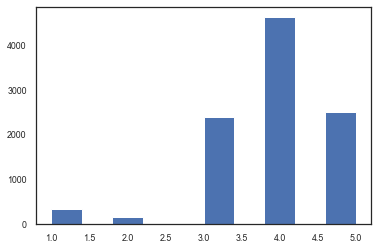

In [32]:
data_row = age_price(data_row)
plt.hist(data_row['age_price'])

C:\Users\artemiyb1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


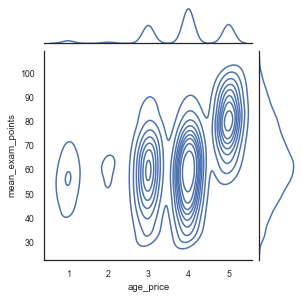

In [33]:
grid = sns.jointplot(data_row['age_price'], data_row['mean_exam_points'], kind='kde')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)

plt.show()

In [34]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = data_categ_features.T @ data_categ_features

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(3949.6226, array([-0.96325195, -0.20685658, -0.1523187 , -0.06608644, -0.03612692,
       -0.02196538], dtype=float32))
(1240.9302, array([-0.24948992,  0.9190229 ,  0.29890794,  0.05860734,  0.01691337,
        0.00920874], dtype=float32))
(1009.77936, array([ 0.08094444,  0.33036008, -0.93935865, -0.041095  , -0.00560068,
       -0.01397619], dtype=float32))
(518.86505, array([-0.04684953, -0.05481321, -0.06708091,  0.99488324,  0.02113137,
        0.00784648], dtype=float32))
(315.9091, array([ 0.02942795,  0.02014831,  0.01470011,  0.02481319, -0.9988492 ,
       -0.01401813], dtype=float32))
(191.89375, array([-0.01695794, -0.00768094, -0.01850399, -0.01002928, -0.01520313,
        0.99948955], dtype=float32))


In [35]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[54.650928005158704, 17.17075105024628, 13.972317144626576, 7.179535801370437, 4.371234105462336, 2.6552338931356627]
Кумулятивная доля дисперсии по компонентам 
[ 54.65092801  71.82167906  85.7939962   92.973532    97.34476611
 100.        ]


Категориальные признаки по главным компонентам соответствуют выводам дисперсионного анализа
physics, chemistry, biology - в наибольшей степени описывают целевое значение

In [36]:
data_row.insert(0, 'free', 1)

После анализа принято решение рассматривать в модели следующие параметры:
 - free
 - age_price (новая переменная)                    
 - years_of_experience    
 - qualification          
 - physics                
 - chemistry              
 - biology                

In [37]:
data_all = ['free', 'years_of_experience', 'qualification', 'physics', 'chemistry', 'biology', 'age_price', 'mean_exam_points']

feature_names = ['free', 'years_of_experience', 'qualification', 'physics', 'chemistry', 'biology', 'age_price']

target_name = 'mean_exam_points'

In [38]:
data_row = data_row[data_all]

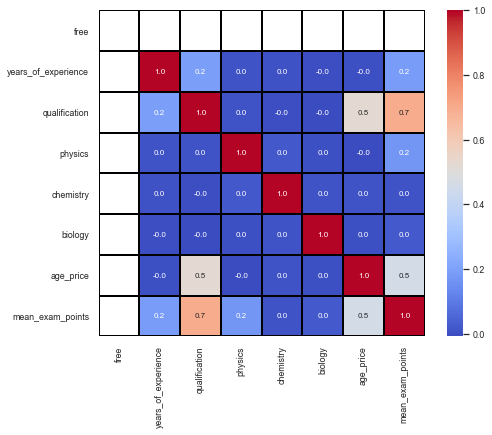

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(data_row.corr(), cmap= 'coolwarm', linewidths=1, fmt='.1f', annot=True, linecolor='black', square=True, annot_kws={'size':8})
plt.show()

In [40]:
# Итоговая функция подготовки данных
class DataPreprocessing:
    def transform(self, X):
        X['age_price'] = 2
        X.loc[((X['age'] < 30) | ((X['age'] >= 30) & (X['age'] < 50)) | (X['age'] >= 50)) & 
              (X['lesson_price'] <= 1000), 'age_price'] = 1
        X.loc[(((X['age'] >= 30) & (X['age'] < 50)) | (X['age'] >= 50)) & 
              (X['lesson_price'] > 2100), 'age_price'] = 5
        X.loc[((X['age'] >= 30) & (X['age'] < 50)) & 
              ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 4
        X.loc[(X['age'] >= 50) & 
              ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 3
        X.loc[(X['age'] < 30) & 
              (X['lesson_price'] > 2100), 'age_price'] = 3
        X.loc[(X['age'] < 30) & 
              ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 2
        
        X.insert(0, 'free', 1)
        
        all_data = ['Id', 'free', 'years_of_experience', 'qualification', 'physics', 'chemistry', 'biology', 'age_price']
        feature_names = ['free', 'years_of_experience', 'qualification', 'physics', 'chemistry', 'biology', 'age_price']
        X = X[all_data]
        return X


## 4.2 Стандартизация<a class='anchor' id='model_standart'>

Поскольку в итоговом спискевсе имеют примерно одну размерность, стандартизацию можно не проводить

In [41]:
#сохранение датасета
data_row.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')

## 4.3 Разбиение на train/test<a class='anchor' id='model_devide'>

In [42]:
X = data_row[feature_names]
y = data_row[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)

In [43]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred) ** 2)
    return err

In [44]:
def r_2(y, y_pred):
    d1 = y - y_pred
    d2 = y - y.mean()
    r_2 = 1 - d1.dot(d1) / d2.dot(d2)
    return r_2

In [45]:
def evaluate_preds(true_values, pred_values):
    """Оценка качества модели и график preds vs true"""
    r2_m = round(r_2(true_values, pred_values), 3)
    RMSE_m = round(np.sqrt(calc_mse(true_values, pred_values)), 3)
    MSE_m = round(calc_mse(true_values, pred_values), 3)
    print("R2:\t" + str(r2_m) + "\n" +
          "RMSE:\t" + str(RMSE_m) + "\n" +
          "MSE:\t" + str(MSE_m)
         )
    
    plt.figure(figsize=(5,5))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 100], [0, 100], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    plt.show()
    return r2_m, MSE_m

## 4.4 Линейная регрессия<a class='anchor' id='model_lr'>

In [46]:
# классический  GD
def gradient_descent(X, y, iterations, eta=1e-4):
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    
    errors = []
    w_list = [W.copy()]
    for i in range(0, iterations):
        y_pred = np.dot(X, W)
        err = calc_mse(y, y_pred)
        errors.append(err)
        
        dQ = 2/n * X.T @ (y_pred - y) # градиент функции ошибки
        W -= (eta * dQ)
        w_list.append(W.copy())
        
        if i % (iterations / 10) == 0:
            print(f'Iter: {i}, error {err}')
        
    print(f'Final MSE: {calc_mse(y, np.dot(X, W))}')
    return W, errors, w_list

In [47]:
weights_GD, errors_GD, w_list_GD = gradient_descent(X_train, y_train, iterations=5000, eta=1e-3)

Iter: 0, error 4458.896758009791
Iter: 500, error 158.06661664450291
Iter: 1000, error 146.69764272012483
Iter: 1500, error 139.40118602788857
Iter: 2000, error 134.1925716760073
Iter: 2500, error 130.23060209923634
Iter: 3000, error 127.05548700924342
Iter: 3500, error 124.40739225224222
Iter: 4000, error 122.1341557453706
Iter: 4500, error 120.14298999976162
Final MSE: 118.37469705283496


In [48]:
weights_GD

free                   13.123827
years_of_experience     1.165721
qualification          10.412778
physics                 6.192199
chemistry               0.835502
biology                 1.684130
age_price               6.909263
dtype: float64

In [49]:
y_train_pred = np.dot(X_train, weights_GD)

In [50]:
y_train_pred

array([52.45781748, 68.94435706, 62.8705955 , ..., 59.36708086,
       52.85778871, 58.53157905])

In [51]:
r_2(y_train, y_train_pred)

0.44896828616710016

R2:	0.449
RMSE:	10.88
MSE:	118.375


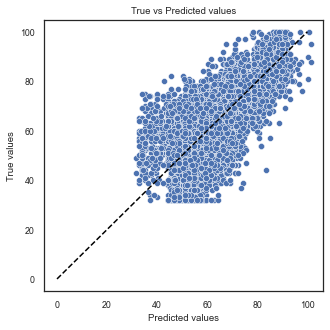

(0.449, 118.375)

In [52]:
evaluate_preds(y_train, y_train_pred)

In [53]:
results_all['Leaner_regress'] = [round(r_2(y_train, y_train_pred), 3), round(calc_mse(y_train, y_train_pred), 3)]

## 4.5 Дерево решений<a class='anchor' id='model_tree'>

In [54]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [55]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [56]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [57]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [58]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [59]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [60]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [61]:
# Построение дерева с помощью рекурсивной функции

def build_tree_tree(data, target):

    gain, t, index = find_best_split(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, target)

    true_data, false_data, true_target, false_target = split(data, target, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_tree(true_data, true_target)
    false_branch = build_tree_tree(false_data, false_target)

    node = Node(index, t, true_branch, false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return node

In [62]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        return self.targets.mean()

In [63]:
def mse(targets):
    return np.mean((targets - targets.mean())**2)

In [64]:
# Нахождение наилучшего разбиения

def find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_mse = mse(targets)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_targets, false_targets, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [65]:
# Построим дерево по обучающей выборке
my_tree = build_tree_tree(np.array(X_train), np.array(y_train))
print_tree(my_tree)

Индекс 2 <= 2.0
--> True:
  Индекс 6 <= 4.0
  --> True:
    Индекс 2 <= 1.0
    --> True:
      Индекс 3 <= 0.0
      --> True:
        Индекс 6 <= 2.0
        --> True:
          Индекс 1 <= 3.0
          --> True:
            Индекс 1 <= 0.0
            --> True:
              Прогноз: 55.0
            --> False:
              Индекс 1 <= 1.0
              --> True:
                Прогноз: 47.5
              --> False:
                Индекс 6 <= 1.0
                --> True:
                  Индекс 4 <= 0.0
                  --> True:
                    Индекс 1 <= 2.0
                    --> True:
                      Прогноз: 52.46666666666667
                    --> False:
                      Прогноз: 53.51851851851852
                  --> False:
                    Прогноз: 56.833333333333336
                --> False:
                  Прогноз: 54.35294117647059
          --> False:
            Индекс 5 <= 0.0
            --> True:
              Индекс 6 <= 1.0
         

In [66]:
train_answers = predict(np.array(X_train), my_tree)

R2:	0.59
RMSE:	9.384
MSE:	88.051


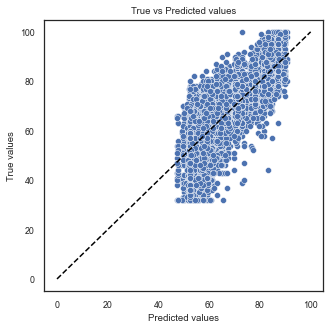

(0.59, 88.051)

In [67]:
evaluate_preds(y_train, train_answers)

In [68]:
results_all['tree'] = [round(r_2(y_train, train_answers), 3), round(calc_mse(y_train, train_answers), 3)]

## 4.6 Градиентный бустинг (XGBoost)<a class='anchor' id='model_gradbust'>

In [69]:
class Leaf_clsf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        
    

class Leaf_regr:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        return self.targets.mean()

In [70]:
class BaseTree:

    def __init__(self,
                 max_depth,
                 max_leaf_nodes,
                 min_leaf_samples,
                 leaf_class):
        self.max_depth = max_depth
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaf_nodes
        self.min_objects = min_leaf_samples
        self.tree = None
        self.Leaf = leaf_class
        
    # Разбиение датасета в узле
    def split(self,
              data,
              labels,
              column_index,
              t):

        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Расчет прироста
    def gain(self,
             left_labels,
             right_labels,
             root):

        # доля выборки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return root - p * self.criterion(left_labels) - (1 - p) * self.criterion(right_labels)   
    
    # Нахождение наилучшего разбиения
    def find_best_split(self,
                        data,
                        labels):

        #  обозначим минимальное количество объектов в узле
        min_samples_leaf = 5

        root = self.criterion(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                    continue

                current_gain = self.gain(true_labels, false_labels, root)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self,
                   data,
                   labels):

        gain, t, index = self.find_best_split(data, labels)
         
        #  Базовый случай 2 - прекращаем рекурсию, когда достигли максимальной глубины дерева
        if self.depth > self.max_depth:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)
        
        #  Базовый случай 3 - прекращаем рекурсию, когда достигли максимального количества листьев
        if len(self.leaves) >= self.max_leaves - 1 or self.depth >= self.max_leaves - 1:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)
        
        #  Базовый случай 4 - прекращаем рекурсию, когда достигли минимального количества объектов в листе
        if len(data) <= self.min_objects:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)
        
         #  Базовый случай 1 - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)

        self.depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)
    
    def predict_object(self,
                       obj,
                       node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, self.Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_object(obj, node.true_branch)
        else:
            return self.predict_object(obj, node.false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        return self
    
    def predict(self, data):
    
        classes = []
        for obj in data:
            prediction = self.predict_object(obj, self.tree)
            classes.append(prediction)
        return classes

In [71]:
class Classification_Tree(BaseTree):
    def __init__(self,
                 max_depth=np.inf,
                 max_leaf_nodes=np.inf,
                 min_leaf_samples=1,
                 leaf_class=Leaf_clsf):
        super().__init__(max_depth=max_depth,
                         max_leaf_nodes=max_leaf_nodes,
                         min_leaf_samples=min_leaf_samples,
                         leaf_class=Leaf_clsf)

    # Расчет критерия Джини
    def criterion(self,
                  labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity

In [72]:
class Regression_Tree(BaseTree):
    def __init__(self,
                 max_depth=np.inf,
                 max_leaf_nodes=np.inf,
                 min_leaf_samples=1,
                 leaf_class=Leaf_regr):
        super().__init__(max_depth=max_depth,
                         max_leaf_nodes=max_leaf_nodes,
                         min_leaf_samples=min_leaf_samples,
                         leaf_class=Leaf_regr)

    # Расчет дисперсии
    def criterion(self, targets):
        return np.mean((targets - targets.mean())**2)

In [73]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [74]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [75]:
def residual(y, z):
    return - (z - y)

In [76]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = Classification_Tree(max_depth=5)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(np.array(X_train), np.array(y_train))
            
            train_errors.append(mean_squared_error(np.array(y_train), gb_predict(np.array(X_train), trees, eta)))
            test_errors.append(mean_squared_error(np.array(y_test), gb_predict(np.array(X_test), trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(np.array(X_train), trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(np.array(X_train), residual(np.array(y_train), target))
            
            train_errors.append(mean_squared_error(np.array(y_train), gb_predict(np.array(X_train), trees, eta)))
            test_errors.append(mean_squared_error(np.array(y_test), gb_predict(np.array(X_test), trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors, target

In [77]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.4

trees, train_errors, test_errors, target = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

R2:	-0.109
RMSE:	15.437
MSE:	238.295


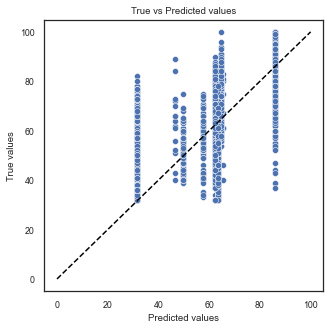

(-0.109, 238.295)

In [78]:
evaluate_preds(y_train, target)

In [79]:
results_all['gboost'] = [round(r_2(y_train, target), 3), round(calc_mse(y_train, target), 3)]

## 4.7 Выбор лучшей модели<a class='anchor' id='choose'>

In [80]:
df = pd.DataFrame(results_all).T
df.columns=['R2', 'MSE']

df

,R2,MSE
Leaner_regress,0.449,118.375
tree,0.590,88.051
gboost,-0.109,238.295


**В целом модели не совсем хорошие. В реализации градиентного бустинга, возможно, есть ошибка. R2 везде не более 70%, однако даже обработка исходных данных без нового показателя не давали точности по r2 более 70%, т.е. можно сказать, что это характеристика предоставленной выборки, что также подтверждается корреляционным анализом.**

В качестве итоговой модели будем использовать модель случайного леса.

# 5. Прогнозирование<a class='anchor' id='estimate'>

## 5.1 Обработка данных<a class='anchor' id='est_ev'>

In [81]:
test = pd.read_csv('test.csv', sep=',')

test = reduce_mem_usage(test)

test = DataPreprocessing().transform(test)

test.head()

Memory usage of dataframe is: 0.84 MB
Memory usage after optimization is: 0.40 MB
Decreased by 52.3%


,Id,free,years_of_experience,qualification,physics,chemistry,biology,age_price
0,10000,1,3.0,1.0,0.0,1.0,0.0,4
1,10001,1,3.0,2.0,0.0,0.0,0.0,4
2,10002,1,1.0,1.0,1.0,0.0,0.0,3
3,10003,1,6.0,3.0,1.0,0.0,1.0,5
4,10004,1,4.0,3.0,1.0,0.0,0.0,5


## 5.2 Применение модели и сохранение<a class='anchor' id='est_save'>

In [82]:
np.array(test[feature_names])

array([[1., 3., 1., ..., 1., 0., 4.],
       [1., 3., 2., ..., 0., 0., 4.],
       [1., 1., 1., ..., 0., 0., 3.],
       ...,
       [1., 5., 1., ..., 0., 0., 4.],
       [1., 0., 2., ..., 0., 0., 4.],
       [1., 5., 2., ..., 0., 0., 4.]])

In [83]:
test['mean_exam_points'] = predict(np.array(test[feature_names]), my_tree)

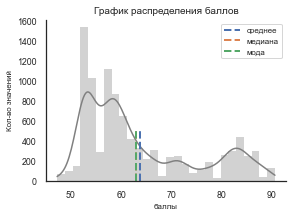

In [84]:
sns.set(font_scale=0.8, style='white')
sns.displot(test['mean_exam_points'], kde=True, color='grey', alpha = 0.35, lw=0, height=3, aspect=1.4)
y = np.linspace(0, 500, 10)
plt.plot([data_mean] * 10, y, label='среднее',  linewidth=2, linestyle='--')
plt.plot([data_median] * 10, y, label='медиана',  linewidth=2, linestyle='--')
plt.plot([data_mode] * 10, y, label='мода',  linewidth=2, linestyle='--')
plt.title('График распределения баллов', fontsize=10)
plt.xlabel('баллы', fontsize=8)
plt.ylabel('Кол-во значений', fontsize=8)
plt.legend(fontsize=8)
plt.show()

In [85]:
test[['Id', 'mean_exam_points']].to_csv('Aberezikov_regression.csv', index=None)